In [1]:
from Utils import create_dist3_task
from Models import ESBN_reimplementation
import numpy as np
import tensorflow as tf
from PIL import Image
import datetime
import tensorboard

In this notebook, we run the relevant code for replicating the original findings of (Webb 2021) and implementing a relational bottleneck as a seperate processing stream in deep language models.
Firstly, we will run the training script for the replication and evaluate the performance of both the esbn, a transformer and the abstractor (Webb 2023).
Secondly, we will integrate the abstractor and the esbn into a small language model and compare the performance with a transformer of similar size.

In [2]:
# Set holdout
m_holdout = 0
y_dim = 4


# Set train parameters
batch_size = 32
train_set_size = 10000
train_proportion = 0.95

# Set test parameters
test_batch_size = 32
test_set_size = 10000

# Todo: improve task creation

# Randomly assigns objects to training or test set
n_shapes = 100
all_shapes = np.arange(n_shapes)
np.random.shuffle(all_shapes)
if m_holdout > 0:
    train_shapes = all_shapes[m_holdout:]
    test_shapes = all_shapes[:m_holdout]
else:
    train_shapes = all_shapes
    test_shapes = all_shapes

# Load images
all_imgs = []
for i in range(n_shapes):
    img_fname = "./imgs/" + str(i) + ".png"
    img = tf.convert_to_tensor(np.array(Image.open(img_fname)), dtype=tf.float32) / 255.
    all_imgs.append(img)
all_imgs = tf.stack(all_imgs)


# Generate training and test sets
train_set, test_set = create_dist3_task.create_task(train_shapes, test_shapes, train_set_size, test_set_size, train_proportion, m_holdout, n_shapes)

train_data = tf.data.Dataset.from_tensor_slices(train_set)
train_data = train_data.map(lambda indices, label : (tf.gather(all_imgs, indices), label))
train_data = train_data.shuffle(train_set_size).batch(batch_size).prefetch(20)
test_data = tf.data.Dataset.from_tensor_slices(test_set)
test_data = test_data.map(lambda indices, label : (tf.gather(all_imgs, indices), label))
test_data = test_data.shuffle(test_set_size).batch(test_batch_size).prefetch(20)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-03-28 12:16:31.942130: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


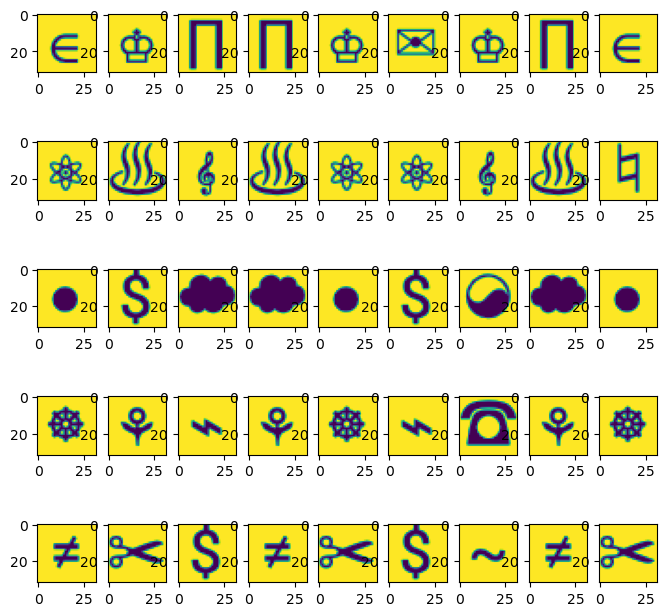

In [3]:
# Show samples of train and test data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 9
rows = 5
i = 0
for (sequence, label) in train_data.take(5):
    for j in range(len(sequence[0])):
        img = sequence[0, j]
        fig.add_subplot(rows, columns, 9*i+j+1)
        plt.imshow(img)
    print(label[0])
    i += 1
plt.show()

In [4]:
# Create model
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model = ESBN_reimplementation.Model2(y_dim)
model.compile(optimizer=optimizer, 
              loss=loss_fn,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [6]:
# Test first model
tf.config.run_functions_eagerly(True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
esbn = ESBN_reimplementation.ESBN(y_dim)
esbn.compile(optimizer=optimizer, 
              loss=loss_fn,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
log_dir = "logs/reimplementation/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

esbn.fit(train_data, 
          epochs=20,
          validation_data=test_data,
          callbacks=[tensorboard_callback])

Epoch 1/20
313/313 [==============================] - 70s 223ms/step - loss: 0.6437 - sparse_categorical_accuracy: 0.6932 - val_loss: 0.3382 - val_sparse_categorical_accuracy: 0.8301
Epoch 2/20
313/313 [==============================] - 69s 221ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.0802 - val_sparse_categorical_accuracy: 0.9734
Epoch 3/20
313/313 [==============================] - 70s 224ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.0583 - val_sparse_categorical_accuracy: 0.9798
Epoch 4/20
313/313 [==============================] - 68s 219ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.0375 - val_sparse_categorical_accuracy: 0.9919
Epoch 5/20
 27/313 [=>............................] - ETA: 46s - loss: 0.0326 - sparse_categorical_accuracy: 0.9931

KeyboardInterrupt: 

In [ ]:
print(tf.keras.activations.softmax(esbn.second_last_sim, axis=1))

tf.Tensor(
[[[9.99819815e-01]
  [1.60598460e-26]
  [7.34103407e-30]
  [1.80269009e-04]
  [7.13729714e-24]
  [1.51892435e-37]
  [3.03478868e-28]
  [3.97749067e-25]]

 [[3.59373095e-23]
  [4.71809879e-04]
  [0.00000000e+00]
  [9.99528170e-01]
  [7.49424859e-20]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.72985049e-09]]

 [[4.64472427e-38]
  [1.73509150e-29]
  [1.00000000e+00]
  [7.46419476e-28]
  [0.00000000e+00]
  [4.18557538e-38]
  [6.50473317e-26]
  [1.13749168e-31]]

 [[5.13643930e-36]
  [8.31643958e-03]
  [2.39571535e-25]
  [2.84473786e-29]
  [9.91683602e-01]
  [1.90175551e-34]
  [2.51981028e-27]
  [1.73260231e-30]]

 [[1.48861731e-27]
  [4.41158534e-22]
  [1.00000000e+00]
  [9.49732521e-24]
  [2.95206912e-26]
  [2.19930761e-31]
  [6.14930881e-26]
  [2.16409306e-26]]

 [[8.80445009e-14]
  [9.49245632e-01]
  [3.08756731e-09]
  [1.07891369e-11]
  [5.07544167e-02]
  [2.75477412e-28]
  [4.91576503e-15]
  [4.19375229e-11]]

 [[1.02891715e-06]
  [1.06878323e-35]
  [0.00000000e+00]
  [9.999

In [ ]:
data = train_data.take(1).as_numpy_iterator()
batch = data.next()


with tf.GradientTape() as tape:
    pred = esbn(batch[0])
    loss = tf.keras.losses.sparse_categorical_crossentropy(batch[1], pred)
grad = tape.gradient(loss, esbn.trainable_variables)
for i in range(len(grad)):
    print(f"parameter: {model.trainable_variables[i]}, value: {grad[i]}")

parameter: <tf.Variable 'model2/encoder_conv/conv2d/kernel:0' shape=(4, 4, 32, 32) dtype=float32, numpy=
array([[[[-3.40923034e-02, -7.59898722e-02, -4.98956516e-02, ...,
           3.49524170e-02, -4.25318889e-02, -4.43508960e-02],
         [ 5.25911674e-02, -1.85471773e-02, -3.39056775e-02, ...,
          -1.96020156e-02, -1.93692744e-02,  3.10181454e-02],
         [-1.84389912e-02, -3.82577628e-03, -8.21554661e-03, ...,
          -4.50432524e-02, -3.29436027e-02,  6.17118850e-02],
         ...,
         [-3.27051431e-03,  2.10700035e-02,  6.76312521e-02, ...,
           1.53399035e-02, -7.05075040e-02,  6.81733415e-02],
         [-6.80539906e-02, -7.55861253e-02, -6.33345246e-02, ...,
          -2.47879885e-02,  5.88022918e-03,  7.12958202e-02],
         [-4.10472788e-02,  6.85493872e-02, -1.30663589e-02, ...,
           3.23262736e-02,  1.88550949e-02,  1.82381496e-02]],

        [[ 4.18922305e-03,  3.39992344e-03, -4.66734096e-02, ...,
          -5.70923463e-02, -3.84311415e-02,  

IndexError: list index out of range

In [ ]:
# Train model
tf.config.run_functions_eagerly(True)
log_dir = "logs/reimplementation/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(train_data, 
          epochs=20,
          validation_data=test_data,
          callbacks=[tensorboard_callback])

Epoch 1/20
313/313 [==============================] - 56s 176ms/step - loss: 1.4068 - categorical_accuracy: 0.2850 - val_loss: 1.3876 - val_categorical_accuracy: 0.0000e+00
Epoch 2/20
313/313 [==============================] - 54s 171ms/step - loss: 1.3935 - categorical_accuracy: 0.3615 - val_loss: 1.3889 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
206/313 [==================>...........] - ETA: 13s - loss: 1.3943 - categorical_accuracy: 0.2573

KeyboardInterrupt: 

In [ ]:
for (sequence, label) in train_data.take(2):
    print(model(sequence))

tf.Tensor(
[[0.31627682 0.20371956 0.2080616  0.27194208]
 [0.3162994  0.20372613 0.2080786  0.27189592]
 [0.3163025  0.20374045 0.20808885 0.27186823]
 [0.3163288  0.20373154 0.20808938 0.27185032]
 [0.31626314 0.20373942 0.208053   0.27194446]
 [0.31629652 0.2037221  0.20809129 0.2718901 ]
 [0.31623033 0.2037133  0.20801653 0.2720398 ]
 [0.31633672 0.20373861 0.20811148 0.2718133 ]
 [0.31633267 0.20372546 0.20812504 0.27181685]
 [0.31626716 0.20373027 0.20803595 0.2719666 ]
 [0.3163246  0.20371996 0.20811787 0.2718376 ]
 [0.31631705 0.20373382 0.20808549 0.2718636 ]
 [0.31622925 0.20372094 0.20803207 0.2720177 ]
 [0.31630984 0.20371665 0.2080843  0.27188912]
 [0.31625974 0.20372799 0.2080767  0.27193558]
 [0.316298   0.20374161 0.20808828 0.27187204]
 [0.31625333 0.20371704 0.20804788 0.27198175]
 [0.316251   0.20373735 0.20803915 0.27197245]
 [0.31626576 0.20373078 0.20803809 0.27196538]
 [0.3163484  0.20371819 0.20812167 0.2718117 ]
 [0.31629774 0.20372255 0.20809501 0.27188465]
 [

In [ ]:
from Utils.train_and_eval import train

train_data_test = tf.data.Dataset.from_tensor_slices(train_set)
train_data_test = train_data_test.shuffle(train_set_size).batch(batch_size).prefetch(20)

test_data_test = tf.data.Dataset.from_tensor_slices(test_set)
test_data_test = test_data_test.shuffle(test_set_size).batch(test_batch_size).prefetch(20)

tf.config.run_functions_eagerly(True)
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
esbn = ESBN_reimplementation.ESBN(y_dim)
esbn.compile(optimizer=optimizer, 
              loss=loss_fn,
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
log_dir = "logs/reimplementation/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

train(esbn, train_data_test, test_data_test, all_imgs, tf.keras.optimizers.Adam(), tf.keras.losses.SparseCategoricalCrossentropy(), epochs=10)

Epoch: 4:  39%|███▉      | 123/313 [00:20<00:31,  6.00it/s]


KeyboardInterrupt: 